In [1]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [2]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [21]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 10000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]

"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"] #for plotting 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
"""

TRAIN_FILENAMES = [f"{label}_res{RES}_10000_events.h5" for label in LABELS]
TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the training histogram files
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)] #The path to the folder containing the testing histogram files

MODEL_NAME = f'resnet_{str(int(time.time()))}' #A unique name for the model
print(MODEL_NAME)
SAVE_FOLDER = "/home/agrefsru/imcalML/results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#transforms=None
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

resnet_1673955971
Running on the GPU


In [4]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)"""

#load data lazily to not run out of memory, no method to load only part of the data yet
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)

trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
print(trainpaths)

train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
#train_data = Hdf5Dataset(trainpaths, ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"], DEVICE, 
                    #shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)

#print(torch.cuda.memory_summary(DEVICE=None, abbreviated=False))

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_3000_events.h5')]
[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_10000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_res50_10000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_res50_10000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_res50_10000_events.h5')]
Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters None
Loaded data with 10000 entries of shape (10000, 50, 50, 3).
Check max value: 13608.056640625.
Loaded data with 10000 entries 

[['SPH_9TEV', 'SPH_9TEV'], ['BH_n4_M8', 'BH_n4_M8'], ['BH_n4_M10', 'BH_n4_M10'], ['BH_n4_M12', 'BH_n4_M12']]
[[0, 0], [1, 1], [2, 2], [3, 3]]
[[4, 42], [3068, 3047], [6062, 6027], [9014, 9037]]
Image shape:  (50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


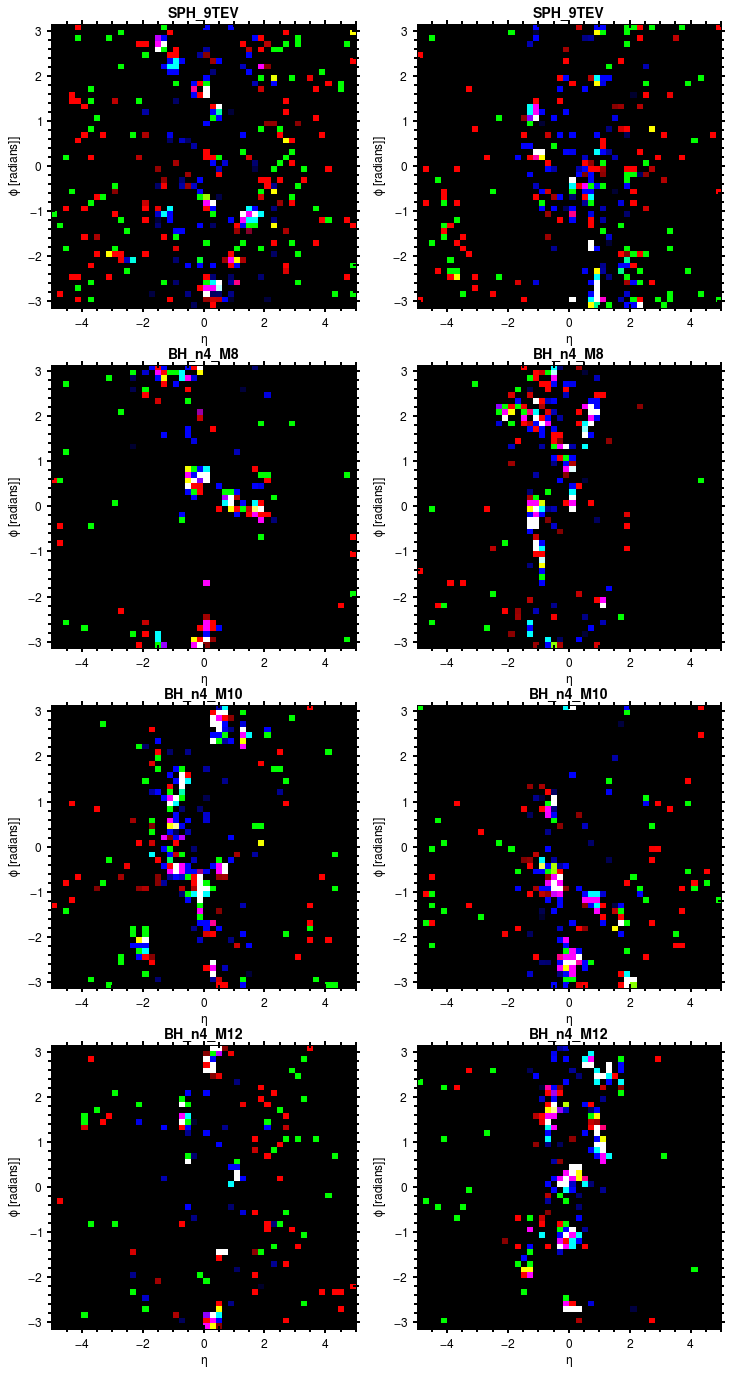

In [22]:
view_data(test_data, 2, CLASSES, PLOT_LABELS, RES, TEST_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[296.84064 308.67776 323.27612 424.14276 443.98096 447.13318 455.32693
 621.0659  816.0948 ]
Looking at image 15015


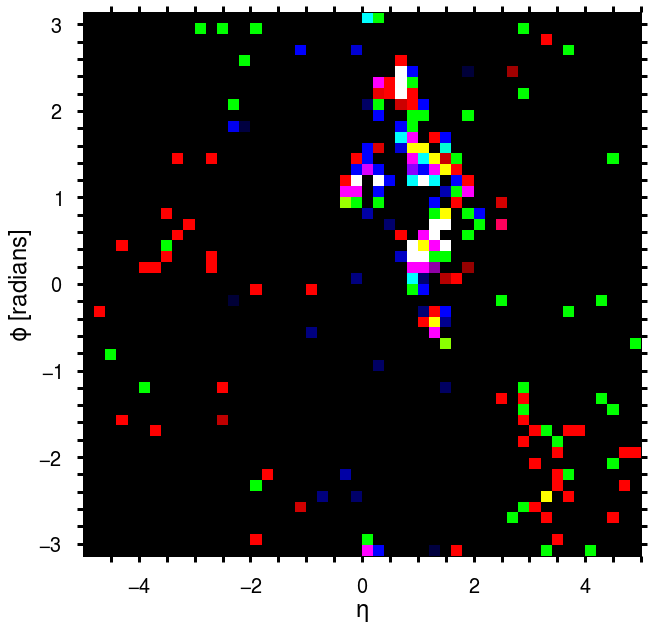

In [6]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


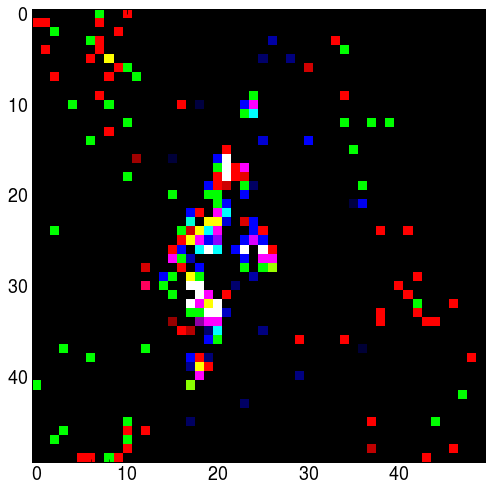

In [7]:
#Check augmentation

if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [8]:
#create NN and test that nothing major is wrong.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))

torch.Size([1, 3, 50, 50])
tensor([[-0.5218,  0.5042,  0.5339, -0.8559]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [9]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, test_data, 2**8, 30, RES, DEVICE, optimizer, scheduler)

100%|██████████| 30/30 [08:36<00:00, 17.21s/it]


In [10]:
#Save model
torch.save(resnet.state_dict(), SAVE_PATH)

In [11]:
k = np.random.randint(0, len(test_data))
testimage, testlabel = test_data[k][0], test_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-9.3311,  3.1772,  3.8967,  0.8776]], device='cuda:0',
       grad_fn=<AddmmBackward0>) tensor([0., 1., 0., 0.], device='cuda:0', dtype=torch.float64)


(0.0, 1.0)

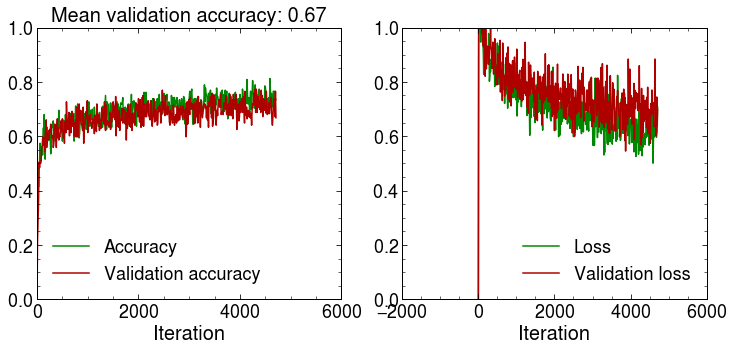

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0)
axs[1].set_ylim(0, 1)

In [13]:
truth, preds, losses, values = predict(resnet, test_data, CLASSES, 1, RES, DEVICE, return_loss=True, return_values=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 12000/12000 [02:04<00:00, 96.31it/s] 


[0.866 0.088 0.024 0.021 0.149 0.696 0.097 0.058 0.059 0.298 0.524 0.119
 0.016 0.065 0.187 0.731]


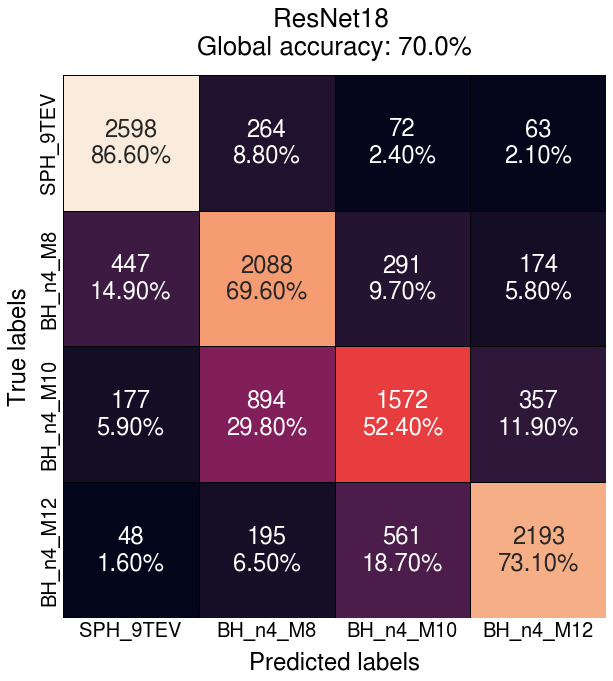

In [23]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24, labelpad= 10)
    ax.set_ylabel('True labels', size=24, labelpad = 10)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [15]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
confusion["Class_1_value"] = values[:,0]
confusion["Class_2_value"] = values[:,1]
confusion["Difference"] = abs(confusion["Class_1_value"] - confusion["Class_2_value"])
arg_chosen_value = np.asarray(preds.tolist())
chosen_value = [values[i, int(arg)].tolist() for i, arg in enumerate(arg_chosen_value)]
confusion["Best choice"] = chosen_value
#wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [16]:
confusion

,Truth,Predictions,Event_ID,Correct_Pred,Losses,Class_1_value,Class_2_value,Difference,Best choice
0,0.0,0.0,0,True,0.151178,8.596947e-01,0.071246,0.788448,0.859695
1,0.0,0.0,1,True,0.115138,8.912432e-01,0.092200,0.799043,0.891243
2,0.0,0.0,2,True,0.027485,9.728897e-01,0.018005,0.954885,0.972890
3,0.0,0.0,3,True,0.129532,8.785067e-01,0.076109,0.802398,0.878507
4,0.0,0.0,4,True,0.151644,8.592941e-01,0.106905,0.752389,0.859294
...,...,...,...,...,...,...,...,...,...
11995,3.0,3.0,11995,True,0.683338,1.651775e-01,0.225569,0.060392,0.504929
11996,3.0,1.0,11996,False,1.384134,2.106770e-05,0.513327,0.513306,0.513327
11997,3.0,3.0,11997,True,0.319595,4.349315e-04,0.064816,0.064381,0.726443
11998,3.0,3.0,11998,True,0.072567,2.218921e-09,0.000105,0.000105,0.930003


In [17]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
#confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
#print(confusion[confusion["Truth"]>0])
print(confusion)

       Truth  Predictions  Event_ID  Correct_Pred     Losses  Class_1_value  \
0        0.0          3.0      2149         False  10.697914   2.259201e-05   
1        0.0          2.0      2388         False   6.983383   9.271610e-04   
2        1.0          3.0      4458         False   6.659504   3.865655e-06   
3        0.0          1.0      2926         False   6.529592   1.459601e-03   
4        1.0          3.0      4568         False   6.452679   1.493134e-07   
...      ...          ...       ...           ...        ...            ...   
11995    3.0          3.0     10752          True   0.000378   1.112949e-11   
11996    3.0          3.0     10715          True   0.000356   3.085061e-12   
11997    3.0          3.0     10647          True   0.000154   8.847829e-12   
11998    3.0          3.0     11120          True   0.000142   5.617966e-12   
11999    3.0          3.0     11030          True   0.000075   6.920143e-18   

       Class_2_value    Difference  Best choice  
0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 420.44574  441.76523  445.54187  485.04736  972.752   1082.3619
 1179.7732  1204.5675  1227.9298 ]
Looking at image 2149


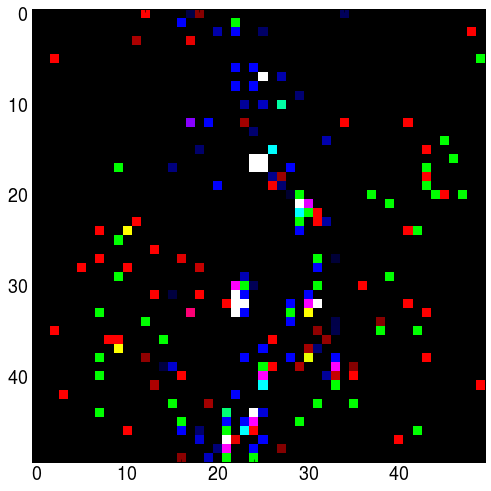

In [18]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Text(0.5, 0, 'Softmax(y)')

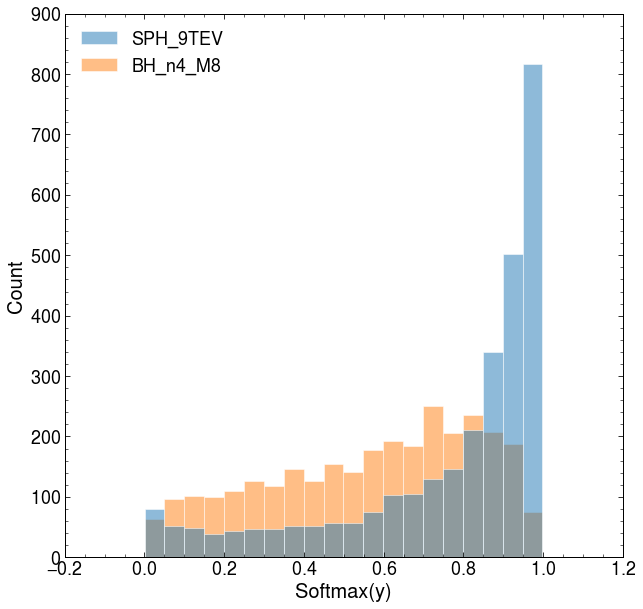

In [24]:
sph_softmax = confusion[confusion["Truth"]==0]["Class_1_value"]
bh_softmax = confusion[confusion["Truth"]==1]["Class_2_value"]
softmaxes = dict(zip(PLOT_LABELS, [sph_softmax, bh_softmax]))

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
sn.histplot(softmaxes, ax=ax, multiple="layer", stat="count", palette="tab10", bins=20)
sn.move_legend(ax, "upper left")
#ax.set_yscale("log")
ax.set_xlabel("Softmax(y)")